In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df=pd.read_csv('AirPassengers.csv')
df.head()

,Month,Passengers
0,15-01-1949,112
1,15-02-1949,118
2,15-03-1949,132
3,15-04-1949,129
4,15-05-1949,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [4]:
df=df.set_index('Month')
df.head()

,Passengers
Month,
15-01-1949,112
15-02-1949,118
15-03-1949,132
15-04-1949,129
15-05-1949,121


## Visualize the time series
### check for seasonality or random patterns, trends

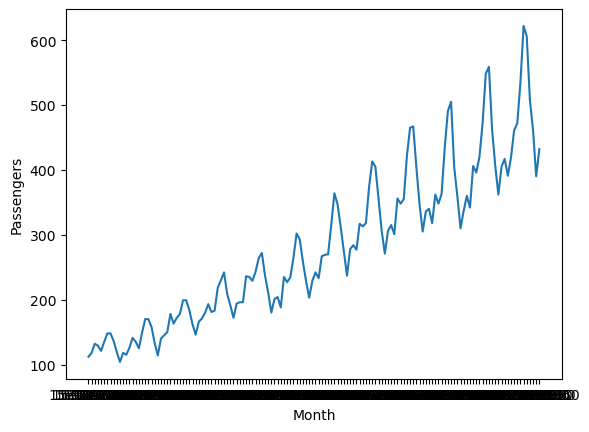

In [5]:
sns.lineplot(x=df.index,y=df['Passengers'])
plt.show()

### check for stationarity
#### method 1: Rolling Stationarity

In [6]:
#determing the rolling statistics
rolmean=df['Passengers'].rolling(window=12).mean()
rolstd=df['Passengers'].rolling(window=12).std()

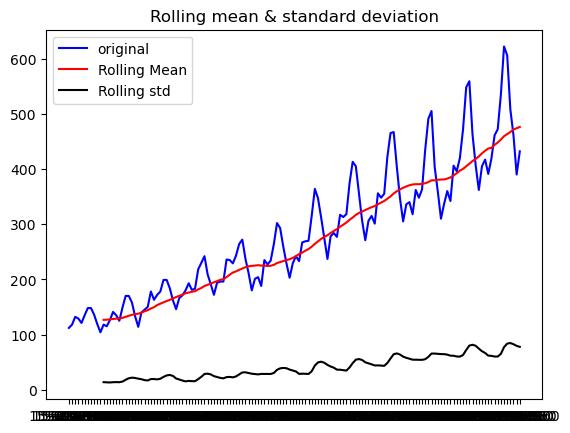

In [7]:
#plot rolling statistics
original=plt.plot(df['Passengers'],color='blue',label='original')
mean=plt.plot(rolmean,color='red',label='Rolling Mean')
std=plt.plot(rolstd,color='black',label='Rolling std')
plt.title('Rolling mean & standard deviation')
plt.legend()
plt.show()

#### Method 2: Augmented Dicky Fuller test

#### for ADF test
 H0:data is non stationary.  
 H1:data is stationary.   
 Based on pvalue accept or reject H0
 

In [8]:
from statsmodels.tsa.stattools import adfuller
adfuller_result=adfuller(df['Passengers'])
adfuller_result

(0.8153688792060423,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

In [9]:
print('p value:',adfuller_result[1])

p value: 0.9918802434376409


##### Time series is not stationary

### Now convert non-stationary data to stationary data
#### Differencing

In [10]:
#apply differencing
diff=df['Passengers']-df['Passengers'].shift(2)
diff

Month
15-01-1949      NaN
15-02-1949      NaN
15-03-1949     20.0
15-04-1949     11.0
15-05-1949    -11.0
              ...  
15-08-1960     71.0
15-09-1960   -114.0
15-10-1960   -145.0
15-11-1960   -118.0
15-12-1960    -29.0
Name: Passengers, Length: 144, dtype: float64

In [11]:
#drop missing values
diff.dropna(inplace=True)
diff

Month
15-03-1949     20.0
15-04-1949     11.0
15-05-1949    -11.0
15-06-1949      6.0
15-07-1949     27.0
              ...  
15-08-1960     71.0
15-09-1960   -114.0
15-10-1960   -145.0
15-11-1960   -118.0
15-12-1960    -29.0
Name: Passengers, Length: 142, dtype: float64

In [12]:
#applying ADF test
adfuller_result=adfuller(diff)
print('p-value of adf test:',adfuller_result[1])

p-value of adf test: 0.03862975767698849


##### Now the time series is stationary

### Step-4 Plot ACF/PACF and find p,d,q parameters

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


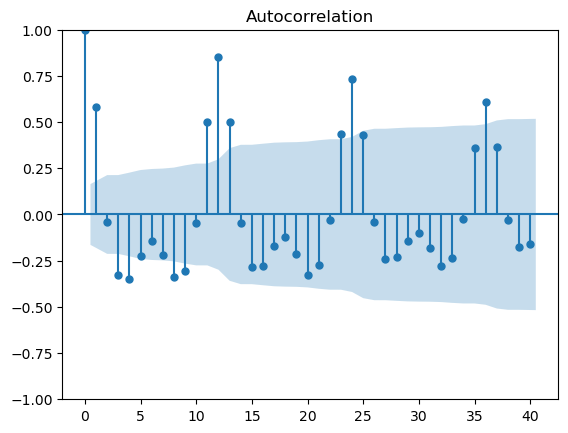

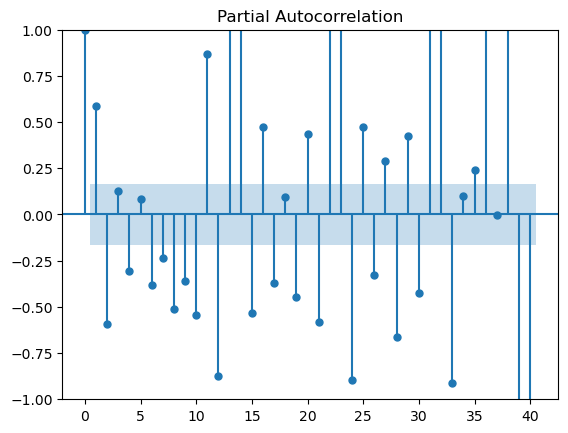

In [14]:
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.api as sm
fig = sm.graphics.tsa.plot_acf(diff,lags=40)
fig = sm.graphics.tsa.plot_pacf(diff,lags=40)

#### From ACF curve, optimal value of q in the ARIMA model must be 1


#### From PACF curve, optimal value of p in the ARIMA model must be 1

## Train test split

#### For time series, we have to use first 80% of records for training and next 20% of records for testing.

#### Here 80%=0.8*412=114 records, so first 114 records we have to use for training


#### NOTE: we should not apply train- test split function, coz it divides the data randomly

In [15]:
y_train=diff[:144]
y_test=diff[114:]

## Build ARIMA model 

In [18]:
from statsmodels.tsa.arima.model import ARIMA
model =ARIMA(diff, order=(1,2,1))
ARIMA=model.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-03-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-04-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-05-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-06-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\

### predict

In [19]:
ypred_test=ARIMA.predict(start=y_test.index[0],end=y_test.index[-1])
ypred_train=ARIMA.predict(start=y_train.index[0],end=y_train.index[-1])

### Evaluation

In [20]:
from sklearn.metrics import r2_score
print("Train R2",r2_score(ypred_train,y_train))
print("Test R2",r2_score(ypred_test,y_test))

Train R2 0.38482191471271243
Test R2 0.42396658841401247


#### here ARIMA model is not performing well coz there is seasonality

### SARIMAX model

#### modelling

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(diff,seasonal_order=(1,2,1,12))
SARIMAX=model.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-03-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-04-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-05-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:557: UserWarning: Parsing '15-06-1949' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  _index = to_datetime(index)
C:\Users\user\anaconda3\

#### Prediction

In [22]:
ypred_train=SARIMAX.predict(start=y_train.index[0],end=y_train.index[-1])
ypred_test=SARIMAX.predict(start=y_test.index[0],end=y_test.index[-1])


#### Evaluation

In [24]:
from sklearn.metrics import r2_score
print("Train R2 of SARIMAX model:", r2_score(ypred_train,y_train))
print("Test R2 of SARIMAX model:", r2_score(ypred_test,y_test))

Train R2 of SARIMAX model: 0.9314734091649821
Test R2 of SARIMAX model: 0.954036114814684
